# 实验结果绘制

读取一个exp目录下，根据超参平均所有的不同种子的数据，画出均值、标准差曲线

In [2]:
from typing import List, Dict
import itertools
import os
import os.path as osp
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()

import rich
from marlpo.utils.debug import printPanel, print
rich.get_console().width += 30

设置需要的列：

In [3]:
# x = 'num_env_steps_trained'
x = 'timesteps_total'
succ = 'SuccessRate'
crash = 'CrashRate'
out = 'OutRate'
maxstep = 'MaxStepRate'
# reward = 'Reward'
all_col = [x, succ, crash, out, maxstep]
succ_col = [x, succ]

自动从一个字典中生成所有参数空间的笛卡尔积：

In [4]:
def get_param_patthern(param_space: Dict[str, List[str]]):
    ''' 
    args:
        param_space: {
            param_name_0: [[label, ...], [param_value, ...]],
            param_name_1: [param_value, ...], NOTE: 参数空间也可以不带标签
            ...
        }
    NOTE: 注意参数顺序

    returns:
        一个字典 包含参数空间的键值对的排列 以其对应的标签 (plt绘图用) 为键 如:
        {
            param_0_label & param_1_lable ... : 'param_name_0=param_0_value_0,param_name_1=param_1_value_0',
            ...
        }
    '''
    msg = {}
    msg['input param space'] = f'total {len(param_space):^3} params.'

    res = {}
    all_param_list = []
    all_label_list = []
    for key, space in param_space.items():
        one_param_list = []
        one_label_list = []
        # 如果有标签简写
        if isinstance(space[0], list) and len(space) == 2:
            labels = space[0]
            values = space[1]
            assert len(labels) == len(values) # 保证标签数与参数值数量一致
            all_label_list.append(labels)
            for v in values:
                one_param_list.append(f'{key}={v}')
        # 如果没有标签简写
        else:
            p_space = space
            for p in p_space:
                one_label_list.append(f'{key}={p}')
                one_param_list.append(f'{key}={p}')
            all_label_list.append(one_label_list)
        all_param_list.append(one_param_list)

    all_param_product = list(itertools.product(*all_param_list)) # list of tuple, a tuple is a product
    all_label_product = list(itertools.product(*all_label_list)) # list of tuple, a tuple is a product
   
    for l, p in zip(all_label_product, all_param_product):
        key = ' & '.join(l)
        # key = l
        pattern = r'(.*?)'.join(p)
        res[key] = pattern

    product_helper_str = 'x'.join([str(len(pl)) for pl in all_param_list])
    msg['param combinations'] = f'total {product_helper_str}={len(res)} combinations:'
    msg['-']= '-'
    for i, k in enumerate(res):
        msg[f'param label {i+1}'] = k
    printPanel(msg, title='generating param spaces')

    return res


Test:

In [5]:
param_space = {
    'use_attention': [['atn', 'mlp'], ['True', 'False']],
    # 'use_attention': [['atn'], ['True']],
    'random_order': [['ro', 'id'], ['True', 'False']],
    'cf': ['True'],
}

get_param_patthern(param_space)

╭──────────── generating param spaces ────────────╮
│ input param space:  total  3  params.           │
│ param combinations: total 2x2x1=4 combinations: │
│ ------------------- --------------------------- │
│ param label 1:      atn & ro & cf=True          │
│ param label 2:      atn & id & cf=True          │
│ param label 3:      mlp & ro & cf=True          │
│ param label 4:      mlp & id & cf=True          │
╰─────────────────────────────────────────────────╯

{'atn & ro & cf=True': 'use_attention=True(.*?)random_order=True(.*?)cf=True',
 'atn & id & cf=True': 'use_attention=True(.*?)random_order=False(.*?)cf=True',
 'mlp & ro & cf=True': 'use_attention=False(.*?)random_order=True(.*?)cf=True',
 'mlp & id & cf=True': 'use_attention=False(.*?)random_order=False(.*?)cf=True'}

In [7]:
# 给定一个实验目录，和一个正则表达式匹配式，筛序出该目录下所有符合该表达式的目录，并返回其中的progress.csv文件内所需要的列
def read_csv_in_dir(exp_dir, param_pattern, columns: list):
    trial_dirs = [entry for entry in os.listdir(exp_dir) if osp.isdir(osp.join(exp_dir, entry))]
    csv_list = []
    all_seeds = []

    seed_pattern = r'start_seed=(\d*)'

    print(f'Reading csv in {exp_dir}...')
    for d in tqdm(trial_dirs):
        if re.search(param_pattern, d):
            match = re.search(seed_pattern, d)
            if match: 
                seed = match.group()[len('start_seed='):]
                all_seeds.append(seed)
            file_path = osp.join(exp_dir, d, 'progress.csv')
            progress = pd.read_csv(file_path)
            data = progress[columns]
            # data['seed'] = int(seed)
            csv_list.append(data)
    
    print(f'Finished reading {len(all_seeds)} seed: ', ', '.join(all_seeds))
    return csv_list


In [8]:
# 输入一个data，包含以同一组数据为x轴的多个种子的多列数据，按相同x值聚集某列的不同种子的数据，并绘制均值、标准差
def plot_mean_std(data, x: str, col: List[str], title=None, lable=None):
    for c in col:
        if c != x:
            mean_values = data.groupby(x)[c].mean()
            std_values = data.groupby(x)[c].std()

            # 绘制均值和标准差曲线
            label = lable if lable else c
            plt.plot(mean_values.index, mean_values.values, label=lable)
            plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, alpha=0.25)

            # 设置图例和标签
            plt.title(title)
            plt.legend(title='', loc='upper left')
            plt.xlabel('Environmental Step')
            plt.ylabel('rate')


简单从一个exp目录根据pattern筛选所有trial，分别读取csv文件，再拼接，然后按x轴聚集不同种子绘制均值、标准差图

In [9]:
def plot_one_exp(exp_dir, param_pattern=None, col=None, title=None, exp_label=None):
    if not param_pattern:
        param_pattern = r'start_seed=(\d*)'
    if not col:
        col = succ_col
    df_list = read_csv_in_dir(exp_dir, param_pattern, col)
    data = pd.concat(df_list)
    plot_mean_std(data, x, col, title=title, lable=exp_label)

#### IPPO
对于IPPO，由于没有超参需要设置，只包含不同种子的trial，只需要聚集不同种子的数据即可。
但IPPO常作为基线跟其他方法对比，所以需要封装好以方便地获取其数据

用于匹配目录名称中种子数的正则pattern:

In [42]:
seed_pattern = r'start_seed=(\d*)'

In [35]:
exp_dir = 'exp_results/IPPO_Intersection_8seeds_30agents'

Reading csv in exp_results/IPPO_Intersection_8seeds_30agents...

100%|██████████| 8/8 [00:00<00:00, 31.48it/s]


Finished reading 8 seed:  12000, 8000, 10000, 6000, 9000, 7000, 11000, 5000

Reading csv in exp_results/IPPO_Intersection_8seeds_30agents_repeat...

100%|██████████| 8/8 [00:00<00:00, 33.02it/s]


Finished reading 8 seed:  5000, 11000, 12000, 10000, 9000, 7000, 8000, 6000

Reading csv in exp_results/IPPO_Intersection_8seeds_30agents_repeat2...

100%|██████████| 8/8 [00:00<00:00, 33.42it/s]


Finished reading 8 seed:  10000, 5000, 6000, 7000, 8000, 9000, 11000, 12000

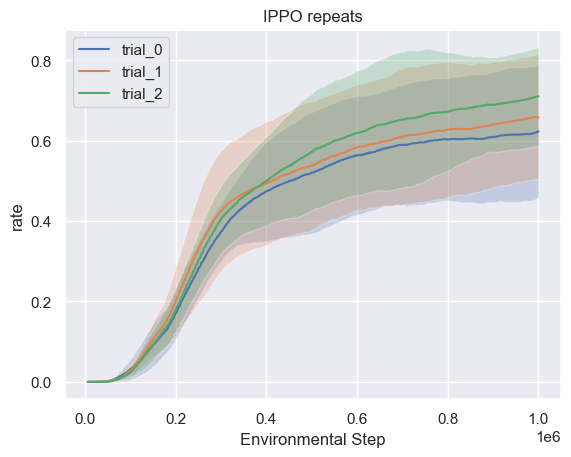

: 

In [46]:
exp_dirs = [
    'exp_results/IPPO_Intersection_8seeds_30agents', 
    'exp_results/IPPO_Intersection_8seeds_30agents_repeat', 
    'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'
]
exp_labels = ['trial_0', 'trial_1', 'trial_2']
for exp_dir, label in zip(exp_dirs, exp_labels):
    plot_one_exp(exp_dir, param_pattern=seed_pattern, col=succ_col, title='IPPO repeats', exp_label=label)

### CCPPO

╭────────── generating param spaces ──────────╮
│ input param space:  total  1  params.       │
│ param combinations: total 2=2 combinations: │
│ ------------------- ----------------------- │
│ param label 1:      fuse_mode=concat        │
│ param label 2:      fuse_mode=mf            │
╰─────────────────────────────────────────────╯

Reading csv in exp_results/CCPPO_Intersection_8seeds_30agents...

100%|██████████| 16/16 [00:00<00:00, 58.49it/s]


Finished reading 8 seed:  11000, 7000, 9000, 8000, 5000, 10000, 12000, 6000

Reading csv in exp_results/CCPPO_Intersection_8seeds_30agents...

100%|██████████| 16/16 [00:00<00:00, 62.75it/s]


Finished reading 8 seed:  9000, 11000, 6000, 7000, 12000, 8000, 10000, 5000

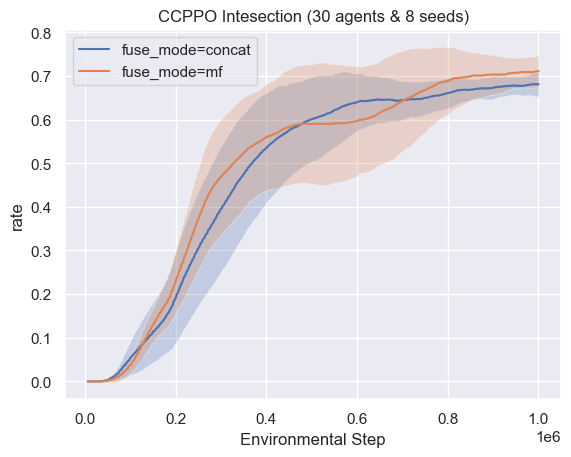

In [10]:
exp_dir = 'exp_results/CCPPO_Intersection_8seeds_30agents'
param_space = {
    'fuse_mode': ['concat', 'mf'],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}

for label, pattern in param_pattern_dict.items():
    plot_one_exp(exp_dir, param_pattern=pattern, col=succ_col, title='CCPPO Intesection (30 agents & 8 seeds)', exp_label=label)

### ARCCPPO

exp param:
- attention 
- random_order

### 不同算法对比

Reading csv in exp_results/IPPO_Intersection_8seeds_30agents...

100%|██████████| 8/8 [00:00<00:00, 31.53it/s]


Finished reading 8 seed:  12000, 8000, 10000, 6000, 9000, 7000, 11000, 5000

╭────────── generating param spaces ──────────╮
│ input param space:  total  1  params.       │
│ param combinations: total 2=2 combinations: │
│ ------------------- ----------------------- │
│ param label 1:      concat                  │
│ param label 2:      mf                      │
╰─────────────────────────────────────────────╯

Reading csv in exp_results/CCPPO_Intersection_8seeds_30agents...

100%|██████████| 16/16 [00:00<00:00, 62.00it/s]


Finished reading 8 seed:  11000, 7000, 9000, 8000, 5000, 10000, 12000, 6000

Reading csv in exp_results/CCPPO_Intersection_8seeds_30agents...

100%|██████████| 16/16 [00:00<00:00, 63.42it/s]


Finished reading 8 seed:  9000, 11000, 6000, 7000, 12000, 8000, 10000, 5000

╭─────────── generating param spaces ───────────╮
│ input param space:  total  2  params.         │
│ param combinations: total 1x1=1 combinations: │
│ ------------------- ------------------------- │
│ param label 1:      mlp & id                  │
╰───────────────────────────────────────────────╯

Reading csv in exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_mlp_no_ro...

100%|██████████| 16/16 [00:00<00:00, 63.24it/s]


Finished reading 8 seed:  5000, 7000, 8000, 11000, 12000, 9000, 10000, 6000

╭───────────── generating param spaces ─────────────╮
│ input param space:  total  4  params.             │
│ param combinations: total 1x1x1x1=1 combinations: │
│ ------------------- ----------------------------- │
│ param label 1:      ^cf & mf & mlp & id           │
╰───────────────────────────────────────────────────╯

Reading csv in exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_cc...

100%|██████████| 128/128 [00:00<00:00, 522.05it/s]


Finished reading 8 seed:  7000, 8000, 12000, 9000, 5000, 6000, 10000, 11000

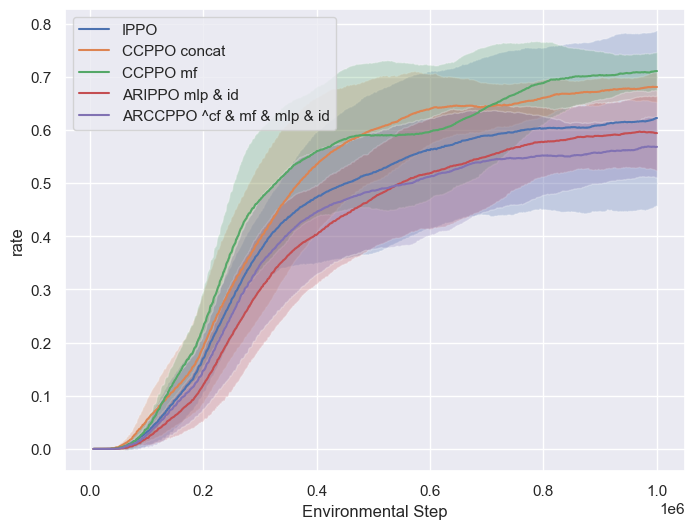

In [16]:
plt.figure(figsize=(8, 6))
# 1. IPPO
ippo_exp_dir = 'exp_results/IPPO_Intersection_8seeds_30agents'
seed_pattern = r'start_seed=(\d*)'
plot_one_exp(ippo_exp_dir, seed_pattern, col=succ_col, exp_label='IPPO')


# 2. CCPPO
ccppo_exp_dir = 'exp_results/CCPPO_Intersection_8seeds_30agents'
param_space = {
    'fuse_mode': [['concat', 'mf'],  ['concat', 'mf']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
for label, pattern in param_pattern_dict.items():
    label = 'CCPPO ' + label 
    plot_one_exp(ccppo_exp_dir, param_pattern=pattern, col=succ_col, exp_label=label)


# 3. ARIPPO
# arccppo_exp_dir = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn'
mlp_no_ro_dir_1 = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_mlp_no_ro'
param_space = {
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    'use_attention': [['mlp'], ['False']],
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    # 'random_order': [['ro'], ['True']],
    'random_order': [['id'], ['False']],
    # 'random_order': [['ro', 'id'], ['True', 'False']],
    # 'random_order': [(''), ['True']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
for label, pattern in param_pattern_dict.items():
    label = 'ARIPPO ' + label 
    plot_one_exp(mlp_no_ro_dir_1, param_pattern=pattern, col=succ_col, exp_label=label)

# 4. ARCCPPO
exp_dir = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_cc'
param_space = {
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    # 'counterfactual': [['cf', '^cf'], ['True', 'False']],
    'counterfactual': [['^cf'], ['False']],
    'fuse_mode': [['mf'], ['mf']],
    # 'fuse_mode': [['concat'], ['concat']],
    # 'fuse_mode': [['concat', 'mf'], ['concat', 'mf']],
    'use_attention': [['mlp'], ['False']],
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    # 'random_order': [['ro'], ['True']],
    'random_order': [['id'], ['False']],
    # 'random_order': [['ro', 'id'], ['True', 'False']],
    # 'random_order': [(''), ['True']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
for label, pattern in param_pattern_dict.items():
    label = 'ARCCPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=succ_col, exp_label=label)


# pattern = r'use_attention=True(.*?)random_order=True'
# plot_one_exp(exp_dir=exp_dir, param_pattern=pattern, col=succ_col, exp_label='ARCCPPO (atn & ro)')

# pattern = r'use_attention=True(.*?)random_order=False'
# plot_one_exp(exp_dir=exp_dir, param_pattern=pattern, col=succ_col, exp_label='ARCCPPO (atn & ^ro')

# pattern = r'use_attention=False(.*?)random_order=True'
# plot_one_exp(exp_dir=exp_dir, param_pattern=pattern, col=succ_col, exp_label='ARCCPPO (mlp & ro)')

# pattern = r'use_attention=False(.*?)random_order=False'
# plot_one_exp(exp_dir=exp_dir, param_pattern=pattern, col=succ_col, exp_label='ARCCPPO (mlp & ^ro')

In [17]:
mlp_no_ro_dir = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn/mlp_no_ro_8seeds'
plot_one_exp(arccppo_exp_dir)

NameError: name 'arccppo_exp_dir' is not defined

Reading csv...


100%|██████████| 8/8 [00:00<00:00, 29.13it/s]


Finished reading 8 seed:  5000, 10000, 7000, 6000, 9000, 8000, 12000, 11000
use_attention [['mlp'], ['False']]
random_order [['ro', 'id'], ['True', 'False']]
----
[['use_attention=False'], ['random_order=True', 'random_order=False']]
[['mlp'], ['ro', 'id']]
Reading csv...


100%|██████████| 16/16 [00:00<00:00, 61.04it/s]


Finished reading 8 seed:  8000, 6000, 5000, 12000, 10000, 11000, 7000, 9000
Reading csv...


100%|██████████| 16/16 [00:00<00:00, 65.60it/s]


Finished reading 8 seed:  5000, 7000, 8000, 11000, 12000, 9000, 10000, 6000


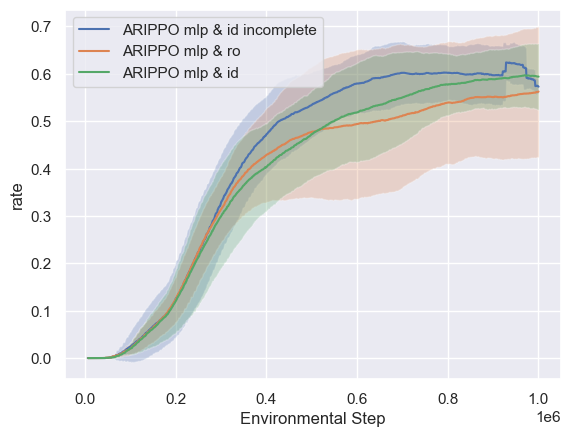

In [153]:
mlp_no_ro_dir_0 = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn/mlp_no_ro_8seeds'
plot_one_exp(mlp_no_ro_dir_0, param_pattern=pattern, col=succ_col, exp_label="ARIPPO mlp & id incomplete")


mlp_no_ro_dir_1 = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_mlp_no_ro'
param_space = {
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    'use_attention': [['mlp'], ['False']],
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    # 'random_order': [['ro'], ['True']],
    # 'random_order': [['id'], ['False']],
    'random_order': [['ro', 'id'], ['True', 'False']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
for label, pattern in param_pattern_dict.items():
    label = 'ARIPPO ' + label 
    plot_one_exp(mlp_no_ro_dir_1, param_pattern=pattern, col=succ_col, exp_label=label)



In [14]:
print('1222')
print('1222')
print('1222')

1222

1222

1222